In [1]:
# Import pustaka untuk pemrosesan audio
import librosa
import librosa.display
from scipy import signal

# Import pustaka untuk memutar audio
import IPython.display as ipd

# Import pustaka untuk manipulasi array
import numpy as np

# Import pustaka untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Import pustaka untuk evaluasi model
from sklearn.metrics import confusion_matrix

# Import pustaka untuk membaca file .pkl
import pickle

# Import pustaka untuk manipulasi dataset
import pandas as pd

# Import pustaka untuk transformasi label
from tensorflow.keras.utils import to_categorical # type: ignore
from sklearn.preprocessing import LabelEncoder

# Import pustaka untuk membagi dataset
from sklearn.model_selection import train_test_split

# Import pustaka untuk manipulasi file dan direktori
import os

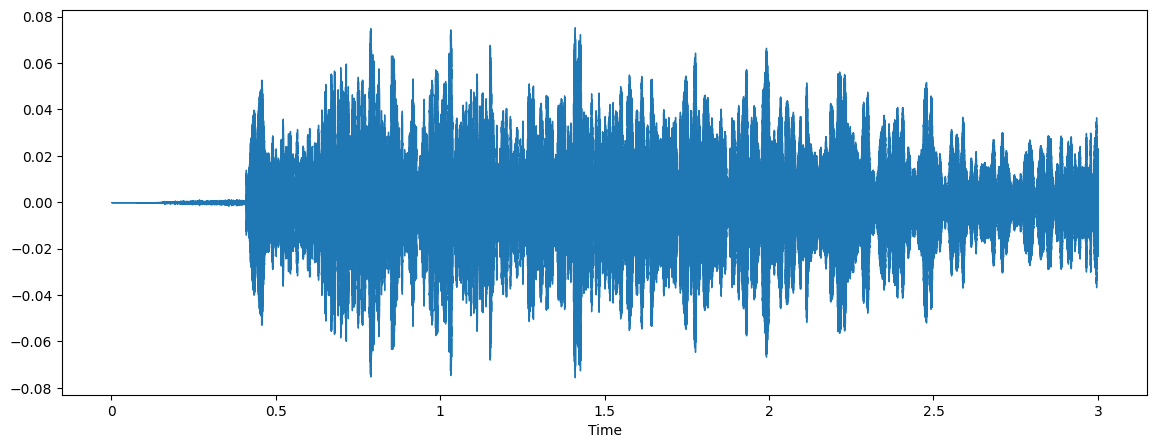

In [2]:
filename = "sounds/sound_1.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

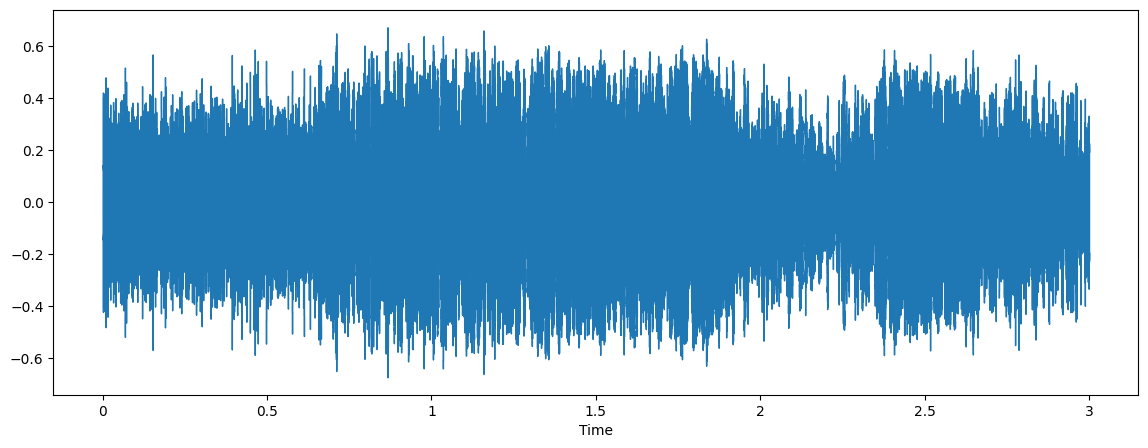

In [3]:
filename = "sounds/sound_11.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

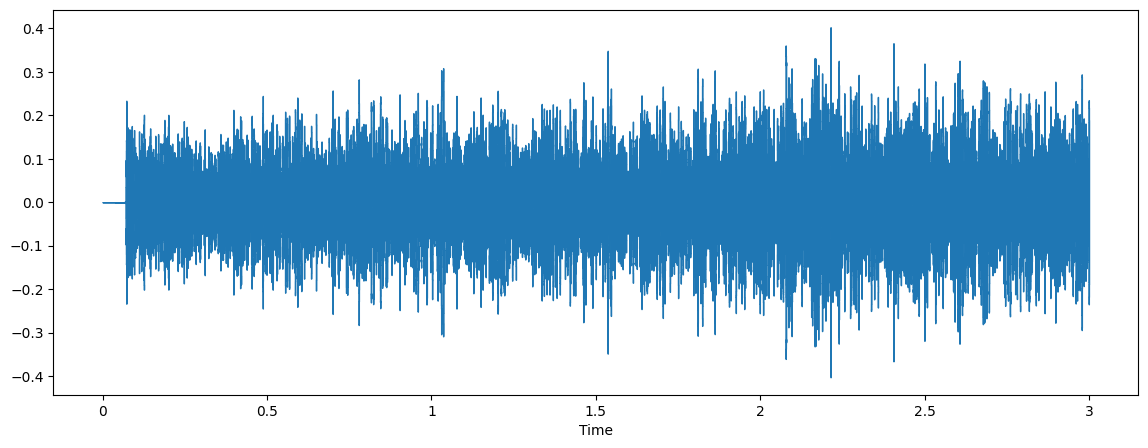

In [4]:
filename = "sounds/sound_21.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

In [5]:
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=80)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [6]:
audio_dataset_path = 'dataset/'

extracted_features = []
for path in os.listdir(audio_dataset_path):
    for file in os.listdir(audio_dataset_path+path+"/"):
        if file.lower().endswith(".wav"):
            file_name = audio_dataset_path+path+"/"+file
            data = features_extractor(file_name)  
            extracted_features.append([data, path])

In [7]:
f = open('./Extracted_Features.pkl', 'wb')
pickle.dump(extracted_features, f)
f.close()

In [8]:
f = open('./Extracted_Features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [9]:
df = pd.DataFrame(Data,columns=['feature','class'])
df.head()

feature      class
0  [-529.2778, 96.09123, -46.660313, -12.780942, ...  ambulance
1  [-521.1548, 95.068886, -53.567135, -10.641551,...  ambulance
2  [-38.777115, 104.3772, -40.953793, 1.848557, -...  ambulance
3  [-118.98806, 113.261086, -38.593113, -1.789974...  ambulance
4  [-164.77432, 126.585754, -35.331738, -14.7402,...  ambulance

In [10]:
df['class'].value_counts()

class
ambulance    200
firetruck    200
traffic      200
Name: count, dtype: int64

In [11]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [12]:
X.shape

(600, 80)

In [13]:
Y.shape

(600,)

In [14]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(Y))

In [15]:
Y[0]

'ambulance'

In [16]:
y[0]

array([1., 0., 0.])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [18]:
y_train.shape

(480, 3)

In [19]:
X_train.shape

(480, 80)

In [20]:
X_test.shape

(120, 80)

In [21]:
y_test.shape

(120, 3)

In [22]:
from keras.layers import * # type: ignore
from keras.models import * # type: ignore
from keras.callbacks import * # type: ignore
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping # type: ignore
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

In [23]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)

Reshaped Array Size (480, 80, 1)


In [24]:
X_train.shape

(480, 80)

In [25]:
import tensorflow as tf
tf.keras.backend.clear_session()

def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
    K.clear_session()
    inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))
    
    #First Conv1D layer
    conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='same', activation=activation)(conv)
    if dropout_rate != 0:
        conv = Dropout(dropout_rate)(conv)
    conv = MaxPooling1D(2)(conv)
    
    #MaxPooling 1D
    conv = GlobalMaxPool1D()(conv)
    
    #Dense Layer 
    conv = Dense(16, activation=activation)(conv)
    outputs = Dense(y_test.shape[1], activation='softmax')(conv)
    
    model = Model(inputs, outputs)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['acc'])
    return model

In [26]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate=0)
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 80, 3)          │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 40, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 40, 16)         │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 909 (3.55 KB)

 Trainable params: 909 (3.55 KB)

 Non-trainable params: 0 (0.00 B)

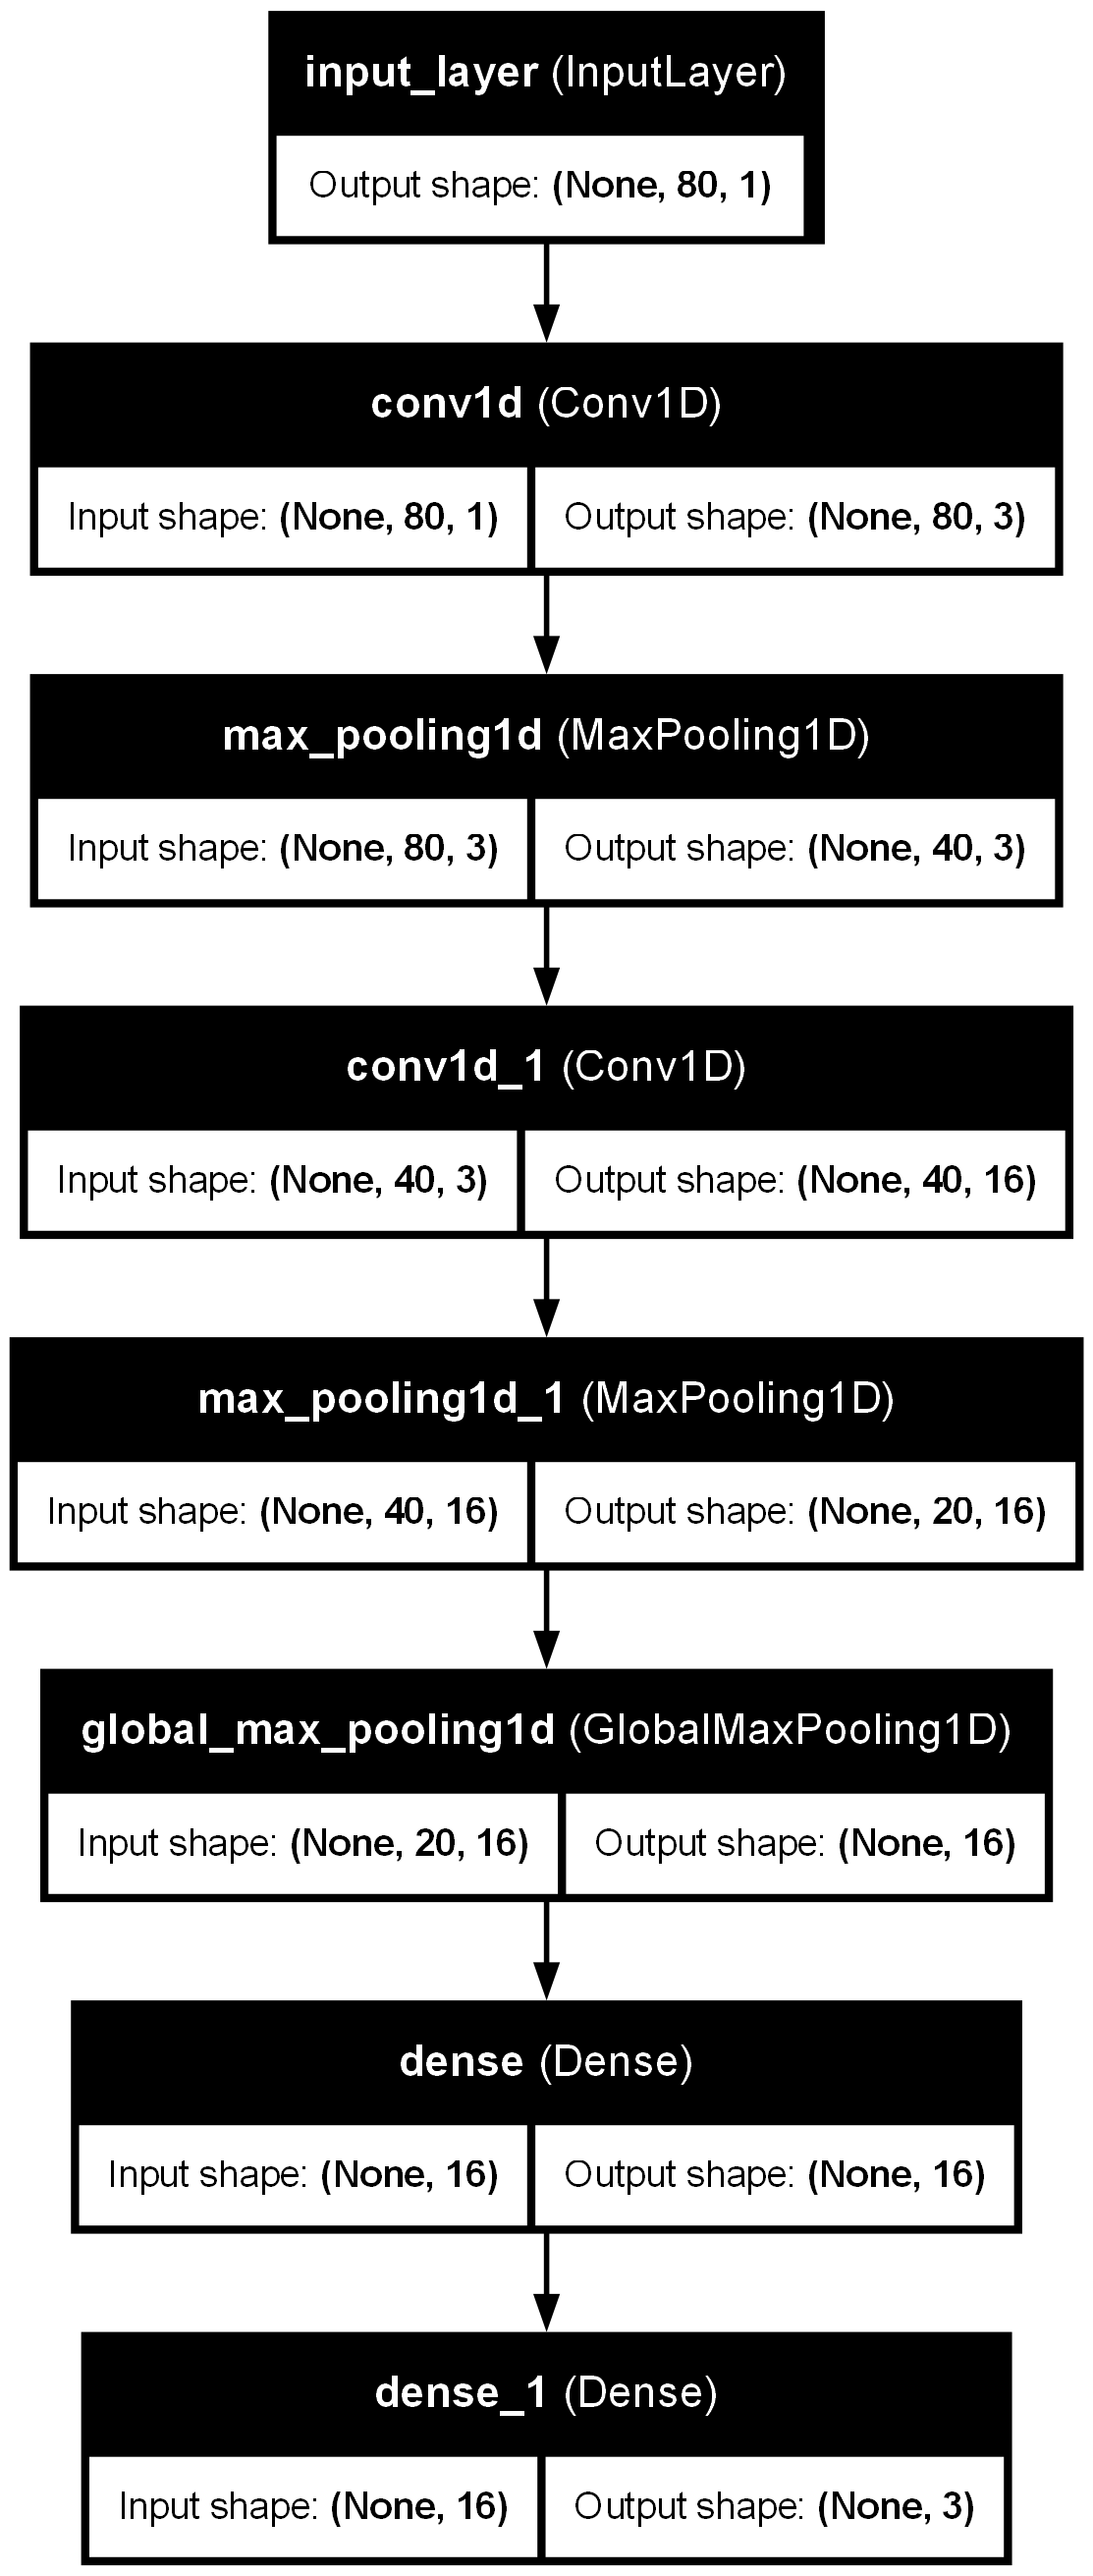

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn, show_shapes=True, show_layer_names=True)


In [28]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200, 
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - acc: 0.3452 - loss: 2.9667 - val_acc: 0.6500 - val_loss: 0.7359
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.5525 - loss: 0.6978 - val_acc: 0.6000 - val_loss: 0.5712
Epoch 3/200
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - acc: 0.6250 - loss: 0.4832

c:\Users\TUF GAMING\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss
  current = self.get_monitor_value(logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.7707 - loss: 0.3687 - val_acc: 0.8250 - val_loss: 0.3406
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.8953 - loss: 0.2306 - val_acc: 0.8250 - val_loss: 0.3167
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8793 - loss: 0.2390 - val_acc: 0.8167 - val_loss: 0.2729
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8953 - loss: 0.2039 - val_acc: 0.8333 - val_loss: 0.2483
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8928 - loss: 0.1839 - val_acc: 0.8333 - val_loss: 0.2324
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8989 - loss: 0.1842 - val_acc: 0.8417 - val_loss: 0.2150
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.8957 - loss: 0.1855 - val_acc: 0.8417 - val_loss: 0.2112
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8962 - loss: 0.1855 - val_acc: 0.8333 - val_loss: 0.2060
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9122 - loss: 0.1562 - v

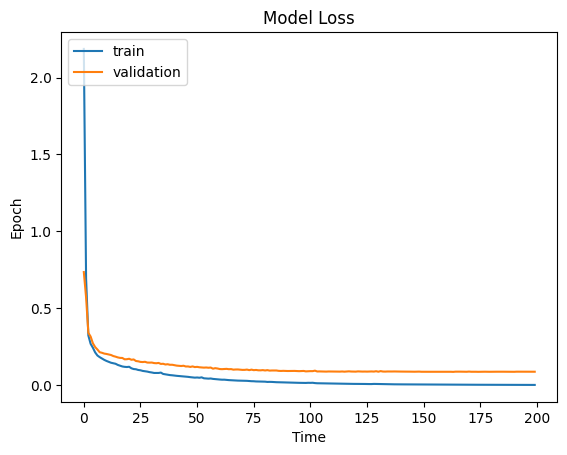

In [29]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [30]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9444 - loss: 0.0779 
Test Accuracy :  0.9416666626930237


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


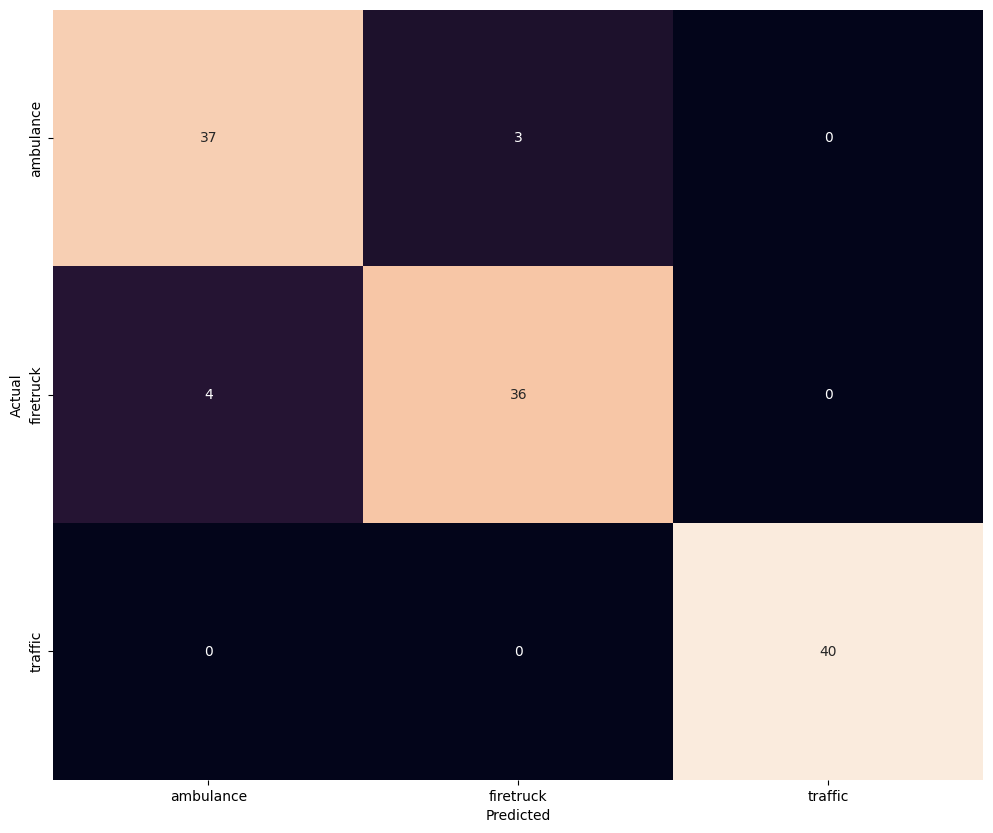

In [31]:
y_pred = model_cnn.predict(X_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [32]:
model_cnn.save('./CNN_Model.keras')

In [33]:
x_train_features  = X_train.reshape(len(X_train),-1, 80)
x_test_features = X_test.reshape(len(X_test), -1, 80)
print("Reshaped Array Size", x_train_features.shape)

Reshaped Array Size (480, 1, 80)


In [34]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.5)(x)
    #dense
    x = Dense(64, activation='relu')(x)
    x = Dense(y_test.shape[1], activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [35]:
model_lstm = lstm(x_train_features)
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       107,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,459 (451.01 KB)

 Trainable params: 115,459 (451.01 KB)

 Non-trainable params: 0 (0.00 B)

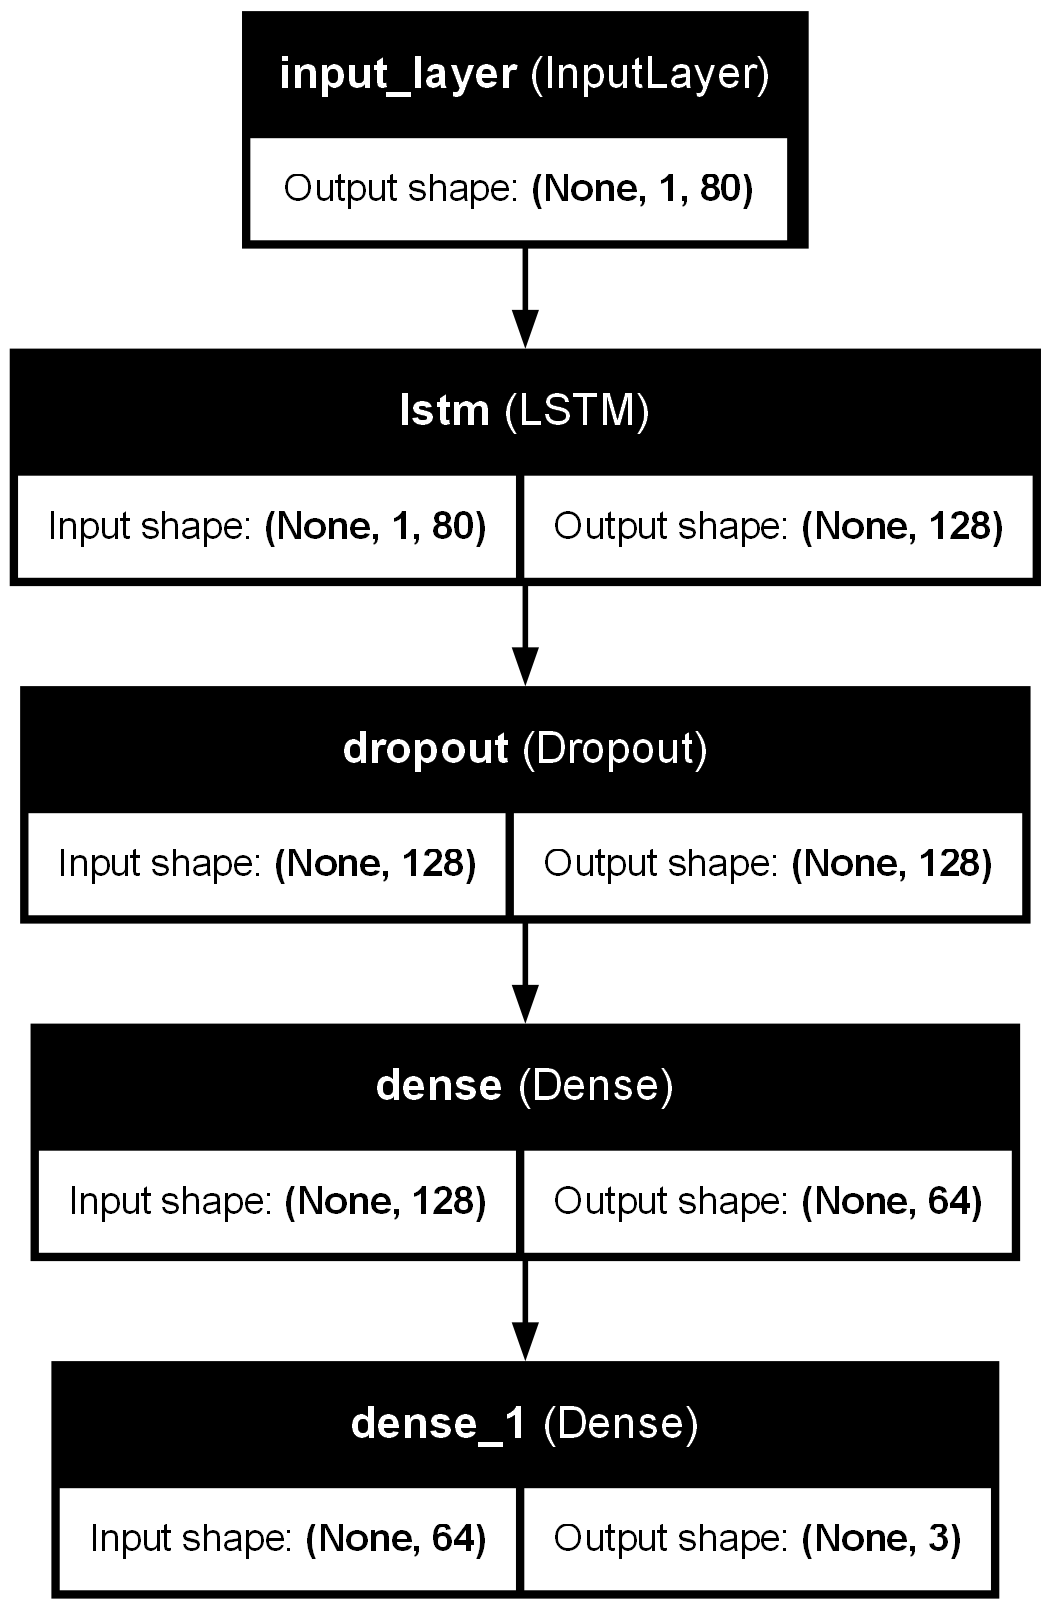

In [36]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [37]:
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [38]:
history = model_lstm.fit(x_train_features, y_train, epochs = 1000,
                        callbacks = [mc],
                        batch_size = 64, validation_data = (x_test_features, y_test))

Epoch 1/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - acc: 0.2969 - loss: 0.7374
Epoch 1: val_acc improved from -inf to 0.63333, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - acc: 0.3741 - loss: 0.6874 - val_acc: 0.6333 - val_loss: 0.5460
Epoch 2/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.6094 - loss: 0.5562
Epoch 2: val_acc improved from 0.63333 to 0.83333, saving model to best_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.6667 - loss: 0.5336 - val_acc: 0.8333 - val_loss: 0.4431
Epoch 3/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.8750 - loss: 0.4684
Epoch 3: val_acc did not improve from 0.83333
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.8761 - loss: 0.4381 - val_acc: 0.8333 - val_loss: 0.3697
Epoch 4/1000
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - acc: 0.8750 - loss: 0.3627
Epoch 4: val_acc did not improve from 0.83333
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8967 - loss: 0.3411 - val_acc: 0.8333 - val_loss: 0.3069
Epoch 5/

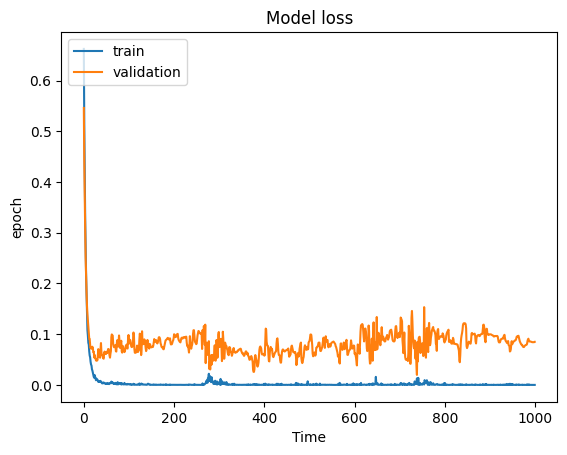

In [39]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [40]:
_,acc = model_lstm.evaluate(x_test_features, y_test)
print("Accuracy:", acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9912 - loss: 0.0433     
Accuracy: 0.9833333492279053


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


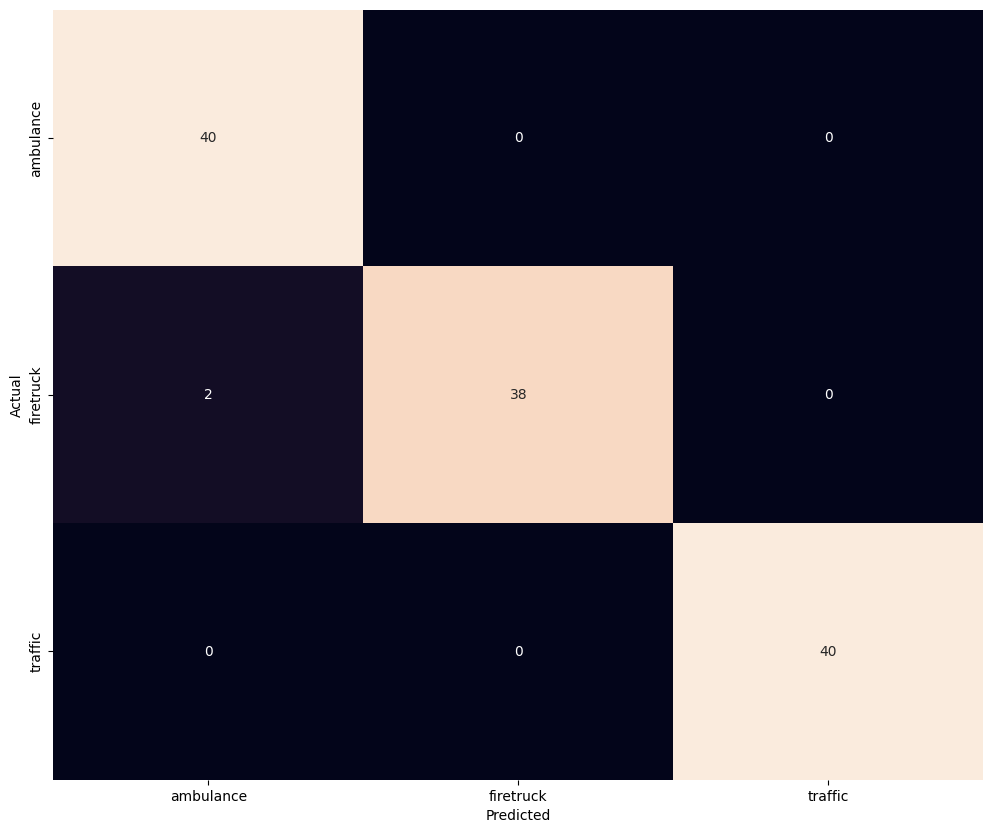

In [41]:
y_pred = model_lstm.predict(x_test_features)

conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=labelencoder.classes_, yticklabels=labelencoder.classes_, cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
model_lstm.save('./LSTM.keras')

In [43]:
import tensorflow as tf

model = tf.keras.models.load_model("CNN_Model.keras")  

In [44]:
import numpy as np
import librosa

def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=80)  

    mfccs = np.mean(mfccs, axis=1).reshape(80, 1)

    return mfccs

In [45]:
def predict_audio(file_path):
    """Prediksi kelas suara dari file audio yang diberikan"""
    features = extract_features(file_path)
    features = np.expand_dims(features, axis=0)  
    prediction = model.predict(features)

    class_labels = ["Ambulance", "Fire Truck", "Traffic"]

    predicted_index = np.argmax(prediction)
    max_prob = np.max(prediction)

    predicted_class = class_labels[predicted_index]

    print(f"Prediksi: {predicted_class} (Confidence: {max_prob:.2f})")

In [46]:
file_path = "sounds/sound_1.wav"  

features = extract_features(file_path)  
print("Shape fitur:", features.shape)  

Shape fitur: (80, 1)


In [47]:
features = extract_features(file_path)
features = np.expand_dims(features, axis=0)

prediction = model.predict(features)

print("Probabilitas prediksi:", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Probabilitas prediksi: [[1.0000000e+00 6.1848624e-24 1.9106381e-32]]


In [48]:
print(prediction)


[[1.0000000e+00 6.1848624e-24 1.9106381e-32]]


In [49]:
file_path = "sounds/sound_3.wav"  # Ubah dengan path file audionya
predict_audio(file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediksi: Ambulance (Confidence: 1.00)


In [50]:
file_path = "sounds/sound_11.wav"  # Ubah dengan path file audionya
predict_audio(file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediksi: Fire Truck (Confidence: 1.00)


In [51]:
file_path = "sounds/sound_21.wav"  # Ubah dengan path file audionya
predict_audio(file_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediksi: Traffic (Confidence: 1.00)
